In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.1 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 35528 
    Total predicted counts          : 35837.48
    Total off counts                : 101831.00

    Total background counts         : 20366.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 500
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 1.67 s, sys: 15.5 ms, total: 1.68 s
Wall time: 1.68 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 36169 
    Total predicted counts          : 35806.08
    Total off counts                : 101674.00

    Total background counts         : 20334.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 35665 
    Total predicted counts          : 35869.68
    Total off counts                : 101992.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_31 

    Total counts                    : 35557 
    Total predicted counts          : 35669.08
    Total off counts                : 100989.00

    Total background counts         : 20197.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_32 

    Total counts                    : 35963 
    Total predicted counts          : 35820.48
    Total off counts                : 101746.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_65 

    Total counts                    : 35446 
    Total predicted counts          : 35668.68
    Total off counts                : 100987.00

    Total background counts         : 20197.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_66 

    Total counts                    : 35354 
    Total predicted counts          : 35748.48
    Total off counts                : 101386.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_92 

    Total counts                    : 35998 
    Total predicted counts          : 35755.68
    Total off counts                : 101422.00

    Total background counts         : 20284.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_93 

    Total counts                    : 35971 
    Total predicted counts          : 35784.88
    Total off counts                : 101568.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_120 

    Total counts                    : 35677 
    Total predicted counts          : 35823.88
    Total off counts                : 101763.00

    Total background counts         : 20352.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_121 

    Total counts                    : 35744 
    Total predicted counts          : 35762.08
    Total off counts                : 101454.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_146 

    Total counts                    : 35942 
    Total predicted counts          : 35778.48
    Total off counts                : 101536.00

    Total background counts         : 20307.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_147 

    Total counts                    : 35424 
    Total predicted counts          : 35850.88
    Total off counts                : 101898.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_172 

    Total counts                    : 35559 
    Total predicted counts          : 35835.68
    Total off counts                : 101822.00

    Total background counts         : 20364.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_173 

    Total counts                    : 35758 
    Total predicted counts          : 35736.68
    Total off counts                : 101327.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_199 

    Total counts                    : 35661 
    Total predicted counts          : 35746.08
    Total off counts                : 101374.00

    Total background counts         : 20274.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_200 

    Total counts                    : 36293 
    Total predicted counts          : 35715.48
    Total off counts                : 101221.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_227 

    Total counts                    : 35721 
    Total predicted counts          : 35808.88
    Total off counts                : 101688.00

    Total background counts         : 20337.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_228 

    Total counts                    : 35648 
    Total predicted counts          : 35775.88
    Total off counts                : 101523.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_254 

    Total counts                    : 35825 
    Total predicted counts          : 35769.68
    Total off counts                : 101492.00

    Total background counts         : 20298.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_255 

    Total counts                    : 35756 
    Total predicted counts          : 35759.48
    Total off counts                : 101441.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_282 

    Total counts                    : 35719 
    Total predicted counts          : 35780.28
    Total off counts                : 101545.00

    Total background counts         : 20309.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_283 

    Total counts                    : 35943 
    Total predicted counts          : 35724.28
    Total off counts                : 101265.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_308 

    Total counts                    : 35716 
    Total predicted counts          : 35815.08
    Total off counts                : 101719.00

    Total background counts         : 20343.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_309 

    Total counts                    : 35815 
    Total predicted counts          : 35727.68
    Total off counts                : 101282.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_340 

    Total counts                    : 35730 
    Total predicted counts          : 35827.28
    Total off counts                : 101780.00

    Total background counts         : 20356.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_341 

    Total counts                    : 35879 
    Total predicted counts          : 35793.28
    Total off counts                : 101610.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_375 

    Total counts                    : 35835 
    Total predicted counts          : 35849.28
    Total off counts                : 101890.00

    Total background counts         : 20378.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_376 

    Total counts                    : 36105 
    Total predicted counts          : 35705.88
    Total off counts                : 101173.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_408 

    Total counts                    : 35959 
    Total predicted counts          : 35803.08
    Total off counts                : 101659.00

    Total background counts         : 20331.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_409 

    Total counts                    : 35828 
    Total predicted counts          : 35651.28
    Total off counts                : 100900.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_435 

    Total counts                    : 35960 
    Total predicted counts          : 35674.48
    Total off counts                : 101016.00

    Total background counts         : 20203.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_436 

    Total counts                    : 35906 
    Total predicted counts          : 35863.28
    Total off counts                : 101960.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_461 

    Total counts                    : 35478 
    Total predicted counts          : 35843.68
    Total off counts                : 101862.00

    Total background counts         : 20372.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_462 

    Total counts                    : 35808 
    Total predicted counts          : 35607.88
    Total off counts                : 100683.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_489 

    Total counts                    : 35942 
    Total predicted counts          : 35820.48
    Total off counts                : 101746.00

    Total background counts         : 20349.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_490 

    Total counts                    : 35627 
    Total predicted counts          : 35773.08
    Total off counts                : 101509.00

    Total background counts        

Text(0, 0.5, 'No. of observations')

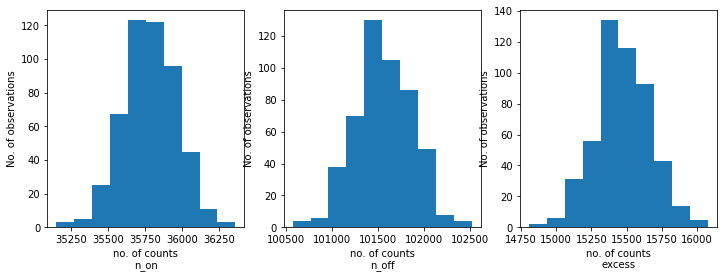

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 1min 3s, sys: 171 ms, total: 1min 3s
Wall time: 1min 3s


In [15]:
results

[{'index': 2.2004131615267624,
  'amplitude': 1.3601486067384558e-12,
  'lambda_': 0.11118392218485627},
 {'index': 2.2186923632409274,
  'amplitude': 1.2740701906278792e-12,
  'lambda_': 0.10355633713292395},
 {'index': 2.2290865097653043,
  'amplitude': 1.2670462380582257e-12,
  'lambda_': 0.10267001537485579},
 {'index': 2.2298212935591573,
  'amplitude': 1.2642889222463049e-12,
  'lambda_': 0.09787260864958808},
 {'index': 2.241520319762935,
  'amplitude': 1.2651277900312725e-12,
  'lambda_': 0.09371184556562533},
 {'index': 2.2227177951774024,
  'amplitude': 1.2632522229738968e-12,
  'lambda_': 0.10172702474076745},
 {'index': 2.2390108273914753,
  'amplitude': 1.2625407510442764e-12,
  'lambda_': 0.0887897117289828},
 {'index': 2.2069527000591647,
  'amplitude': 1.313681166093688e-12,
  'lambda_': 0.11202134541516798},
 {'index': 2.2096971321107435,
  'amplitude': 1.3047687699340683e-12,
  'lambda_': 0.10273424521500699},
 {'index': 2.22604016793442,
  'amplitude': 1.262676439480

In [16]:
import scipy.stats as stats
import math

index: 2.219842704584508 += 0.01348043647633226


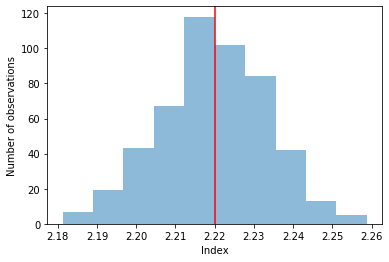

In [17]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

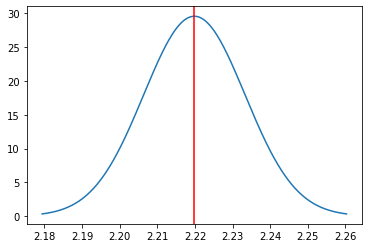

In [18]:
mu = index.mean()
sigma = index.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 500)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.axvline(x=mu, color="red")
plt.show()

Text(0, 0.5, 'Number of observations')

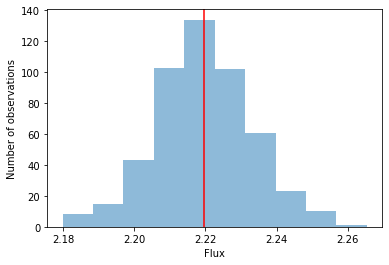

In [19]:
np_hist = np.random.normal(loc=mu, scale=sigma, size=500)
mu = np_hist.mean()
sigma = np_hist.std()
n, bins, patches = plt.hist(x=np_hist, bins=10, alpha=0.5)
plt.axvline(x=mu, color="red")
plt.xlabel('Flux')
plt.ylabel('Number of observations')

Text(0, 0.5, 'Number of observations')

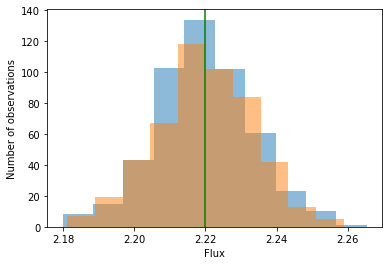

In [20]:
plt.hist(x=np_hist, bins=10, alpha=0.5)
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="green")
plt.xlabel('Flux')
plt.ylabel('Number of observations')

amplitude: 1.2896437787842434e-12 += 3.018332627055102e-14


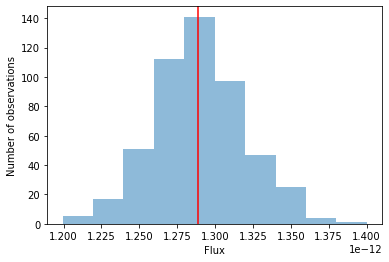

In [21]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

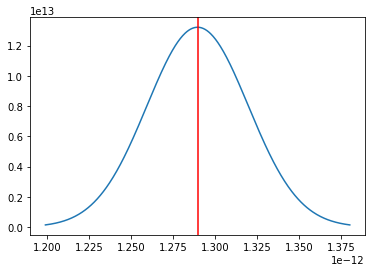

In [22]:
mu = amplitude.mean()
sigma = amplitude.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 500)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.axvline(x=mu, color="red")
plt.show()

Text(0, 0.5, 'Number of observations')

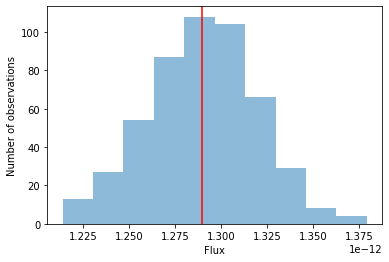

In [23]:
np_hist = np.random.normal(loc=mu, scale=sigma, size=500)
mu = np_hist.mean()
sigma = np_hist.std()
n, bins, patches = plt.hist(x=np_hist, bins=10, alpha=0.5)
plt.axvline(x=mu, color="red")
plt.xlabel('Flux')
plt.ylabel('Number of observations')

Text(0, 0.5, 'Number of observations')

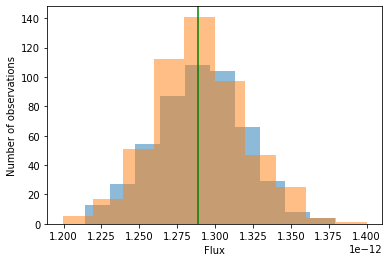

In [24]:
plt.hist(x=np_hist, bins=10, alpha=0.5)
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="green")
plt.xlabel('Flux')
plt.ylabel('Number of observations')

lambda_: 0.10046312364632183 += 0.009071331494553594


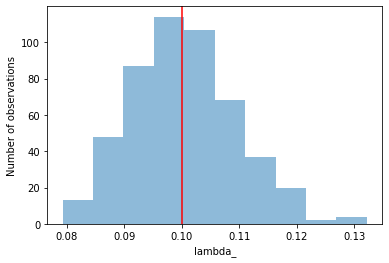

In [25]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")

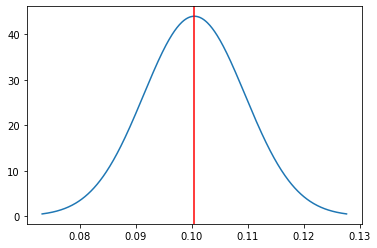

In [26]:
mu = lambda_.mean()
sigma = lambda_.std()
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 500)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.axvline(x=mu, color="red")
plt.show()

Text(0, 0.5, 'Number of observations')

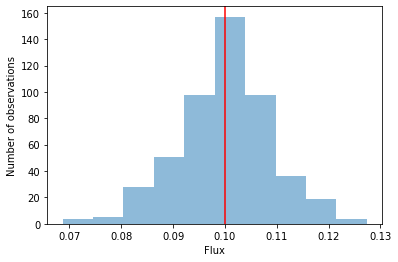

In [27]:
np_hist = np.random.normal(loc=mu, scale=sigma, size=500)
mu = np_hist.mean()
sigma = np_hist.std()
n, bins, patches = plt.hist(x=np_hist, bins=10, alpha=0.5)
plt.axvline(x=mu, color="red")
plt.xlabel('Flux')
plt.ylabel('Number of observations')

Text(0, 0.5, 'Number of observations')

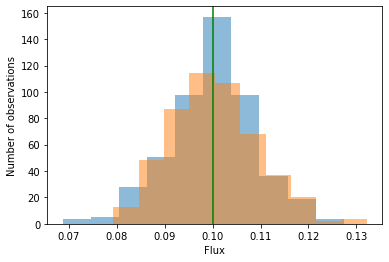

In [28]:
plt.hist(x=np_hist, bins=10, alpha=0.5)
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="green")
plt.xlabel('Flux')
plt.ylabel('Number of observations')

In [29]:
simu = ExpCutoffPowerLawSpectralModel(
    index=index.mean(),
    amplitude=amplitude.mean() * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=lambda_.mean() * u.Unit("TeV-1"),
    alpha = 1,
)
print(simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.290e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 1.005e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


<function matplotlib.pyplot.show(*args, **kw)>

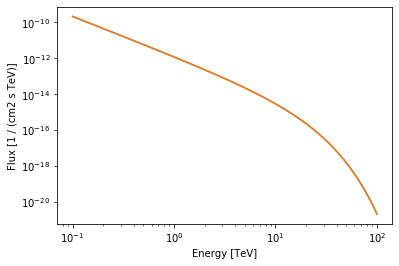

In [30]:
energy_range = [0.1, 100] * u.TeV
model_simu.plot(energy_range)
simu.plot(energy_range)
plt.show